In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import pickle

import numpy as np

In [2]:
with open('../data/CIFAR10/batches.meta', 'rb') as f:
    meta = pickle.load(f)
    
class_names = dict(zip(list(range(10)), meta['label_names']))

In [3]:
transform_list = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1,)),
])

train = datasets.CIFAR10('../data/CIFAR10/train', train=True, download=True, transform=transform_list)
test = datasets.CIFAR10('../data/CIFAR10/test', train=False, download=True, transform=transform_list)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

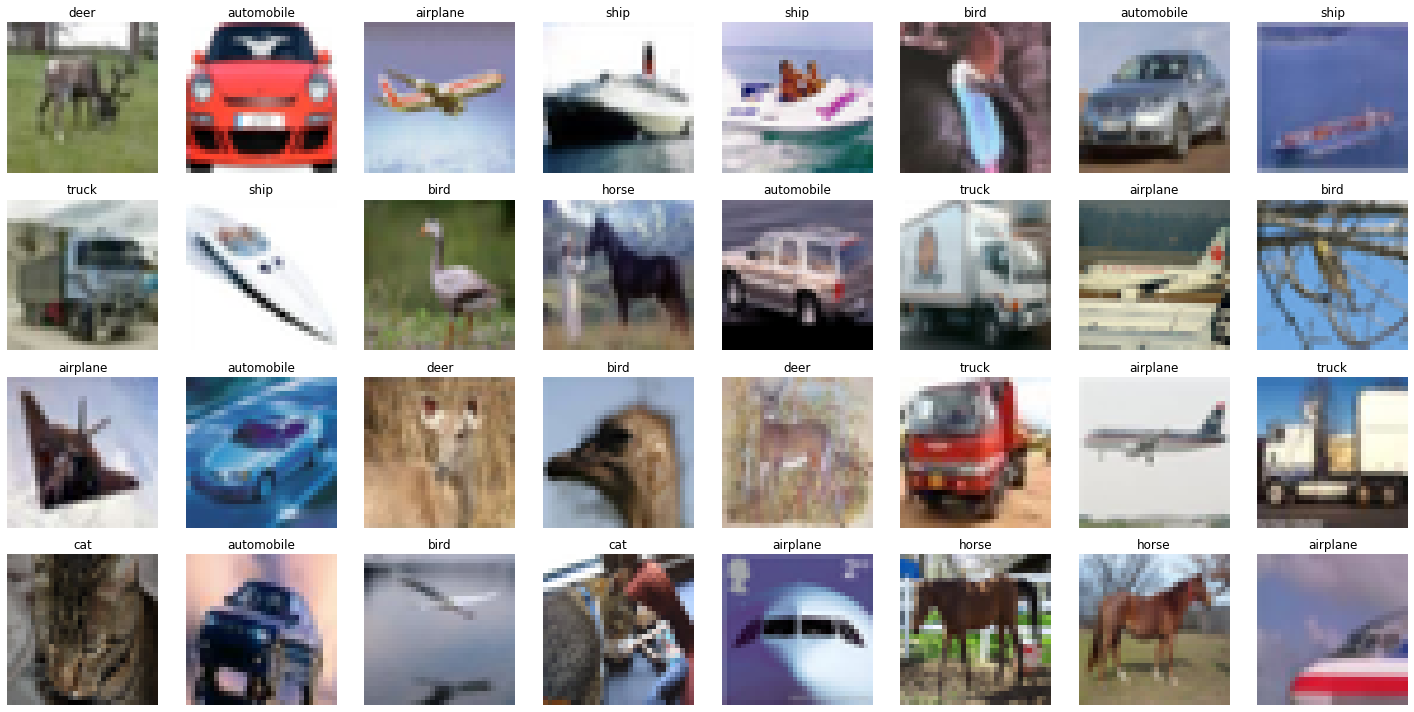

In [5]:
batch, labels = next(iter(trainset))

f = plt.figure(figsize=(20, 10))

n_rows = 8
n_cols = 4

for i in range(n_cols*n_rows):
    ax = f.add_subplot(n_cols, n_rows, i+1)
    ax.axis('off')
    plt.imshow(batch[i].permute(1,2,0)+.5)
    plt.title(class_names[int(labels[i])])
    
plt.tight_layout()

In [10]:
def conv_block(in_ch, inner_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, inner_ch, kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(.1),
        nn.Conv2d(inner_ch, out_ch, kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(.1),
        nn.MaxPool2d(2, 2),
        nn.Dropout2d(.25)
    )

def fc_block(in_f, inner_f, *args, **kwargs):
    return nn.Sequential(
        nn.Linear(in_f, inner_f),
        nn.LeakyReLU(.1),
        nn.Dropout(0.5),
        nn.Linear(inner_f, 10),
        nn.Softmax(dim=1)
    )

def init_weights(block):
    for l in block:
        if isinstance(l, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(l.weight)

class Model(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = conv_block(3, 16, 32)
        init_weights(self.conv1)
        self.conv2 = conv_block(32, 32, 64)
        init_weights(self.conv2)
        
        self.fc = fc_block(64*8*8, 256)
        init_weights(self.fc)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = x.view(-1, 64*8*8)
        
        x = self.fc(x)
        
        return x

In [11]:
def evaluate_accuracy_and_loss(model, testset):
    '''
    Evaluates both model accuracy and loss on a given dataset
    
    model - model to evaluate
    testset - dataset to evaluate model on
    
    Returns tuple (accuracy, mean loss)
    '''
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in testset:
            images, labels = batch
            output = model(images.cuda())            
            for idx, i in enumerate(output):
                if torch.argmax(i) == labels[idx]:
                    correct += 1
                total += 1
                
    return correct/total

In [ ]:
%%time

model = Model().cuda()
epochs = 10

optimizer = optim.Adamax(model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss()

for e in range(epochs):
    print('Epoch: %s' % str(e+1))
    
    model.train()
    for param_group in optimizer.param_groups:
        param_group['lr'] = 5e-3*0.9**e
    
    for i, (batch, labels) in enumerate(trainset):
        
        optimizer.zero_grad()
        output = model(batch.cuda())
        
        loss = criterion(output, labels.cuda())*128
        loss.backward()
        
        optimizer.step()
        
    else:
        model.eval()
        print('Accuracy: %.3f' % evaluate_accuracy_and_loss(model, testset))

Epoch: 1
Accuracy: 0.421
Epoch: 2
Accuracy: 0.462
Epoch: 3
Accuracy: 0.506
Epoch: 4
Accuracy: 0.544
Epoch: 5
Accuracy: 0.563
Epoch: 6
Accuracy: 0.585
Epoch: 7
Accuracy: 0.610
Epoch: 8
Accuracy: 0.622
Epoch: 9
Accuracy: 0.633
Epoch: 10


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

print(tf.__version__)
print(keras.__version__)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

NUM_CLASSES = 10

# normalize inputs
x_train = x_train/255 - .5
x_test = x_test/255 - .5
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

def make_model():
    with tf.device('/gpu:0'):
        model = Sequential()

        model.add(Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 3)))
        model.add(LeakyReLU(.1))
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(.1))
        model.add(MaxPooling2D(pool_size=(2, 2)))    
        model.add(Dropout(.25))

        model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(.1))
        model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(.1))
        model.add(MaxPooling2D(pool_size=(2, 2)))    
        model.add(Dropout(.25))

        model.add(Flatten())

        model.add(Dense(256))
        model.add(LeakyReLU(0.1))
        model.add(Dropout(0.5))
        model.add(Dense(10))
        model.add(Activation("softmax"))

    return model

INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

Using TensorFlow backend.


2.0.0
2.2.4-tf
Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [2]:
%%time

# fit model
model.fit(
    x_train, y_train, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    shuffle=True,
    verbose=1
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 23s 464us/step - loss: 1.3351 - accuracy: 0.5216 - val_loss: 0.9739 - val_accuracy: 0.6568
Epoch 2/10
50000/50000 [==============================] - 16s 320us/step - loss: 0.9561 - accuracy: 0.6673 - val_loss: 0.8039 - val_accuracy: 0.7242
Epoch 3/10
50000/50000 [==============================] - 16s 322us/step - loss: 0.8281 - accuracy: 0.7113 - val_loss: 0.8007 - val_accuracy: 0.7207
Epoch 4/10
50000/50000 [==============================] - 16s 322us/step - loss: 0.7561 - accuracy: 0.7365 - val_loss: 0.6873 - val_accuracy: 0.7673
Epoch 5/10
50000/50000 [==============================] - 17s 334us/step - loss: 0.7049 - accuracy: 0.7537 - val_loss: 0.6953 - val_accuracy: 0.7652
Epoch 6/10
50000/50000 [==============================] - 16s 320us/step - loss: 0.6652 - accuracy: 0.7664 - val_loss: 0.6693 - val_accuracy: 0.7723
Epoch 7/10
50000/50000 [==============================] 